 # 03: Exposure Modeling & LATE Analysis - Decomposing CATE in Non-Compliance Settings

 Standard CATE conflates deliverability with responsiveness in severe non-compliance (3.6% exposure rate). We decompose CATE into who can be reached (P(E)) and who responds when reached (LATE), enabling differentiated bidding strategies in auction environments. Decomposition reveals ads are highly effective (2.86pp lift when delivered, 24× larger than 0.12pp ITT)—the challenge is reachability, not ad performance

 **The Decomposition:**
 ```
 Standard CATE (Black Box):
   Treatment Assignment ──────────────→ Conversion
        CATE(X) = E[Y|T=1,X] - E[Y|T=0,X]

 Decomposed Framework:
   Treatment Assignment ──→ Exposure ──→ Conversion
         P(E|T=1,X)          LATE(X)
    "Who can be reached"  "Who responds"

   CATE(X) ≈ P(Exposure|T=1,X) × LATE(X)
 ```

 CATE treats assignment→conversion as a single effect. We decompose it into two stages: (1) assignment→exposure probability captures deliverability in ad auctions, (2) exposure→conversion effect (LATE) captures true responsiveness. Treatment assignment serves as an instrument for exposure, enabling LATE estimation

 **LATE Uniform vs LATE(X):**
 - **LATE uniform (2.86pp):** Average causal effect assuming constant exposure effect across all users
 - **LATE(X) (mean 2.71pp, range -7pp to 48pp):** Heterogeneous treatment effects—some users respond more than others when exposed
 - Both recover the true ad effect, but LATE(X) enables targeting high-responders beyond just high-reachability users

 **Structure:**
 - **Part A**: Exposure Propensity Modeling - P(exposure|T=1,X) for deliverability analysis
 - **Part B**: LATE Estimation with Instrumental Variables - causal effect of exposure on conversion
 - **Part C**: Performance Comparison and Business Framework - quantified performance-interpretability tradeoffs

 **Key Findings:**
 - Ad exposure drives 2.86pp lift (0.19%→3.05%), 24× larger than 0.12pp ITT diluted by 3.6% compliance
 - Exposure-only modeling achieves 95% of CATE performance, proving deliverability dominates CATE signal
 - Full decomposition P(E)×LATE(X) retains 90% performance while enabling differentiated bidding strategies

 **Key Numbers at a Glance**
 - **Control baseline:** 0.19% conversion rate
 - **ITT effect:** 0.12pp (assignment→conversion, diluted by non-compliance)
 - **LATE uniform:** 2.86pp (exposure→conversion, true ad effect)
 - **LATE(X) mean:** 2.71pp (heterogeneous effects, std 2.37pp)
 - **CATE baseline:** 0.1753 Qini (X-learner, assignment→conversion)
 - **Full decomposition:** 0.1580 Qini (-10%, separates exposure from ad effectiveness)


In [ ]:
import polars as pl
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from itertools import product
from econml.metalearners import TLearner, SLearner, XLearner
from econml.dml import NonParamDML
from sklearn.base import BaseEstimator, RegressorMixin
from sklift.metrics import qini_auc_score, uplift_auc_score, uplift_curve
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
# Plot settings
plt.style.use('default')
sns.set_palette("husl")

# Helper function for outputting probabilities instead of discrete predictions
class ClassifierAsRegressor(BaseEstimator, RegressorMixin):
    """Wrapper to make a classifier behave like a regressor by outputting probabilities"""
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y):
        self.classifier.fit(X, y)
        return self

    def predict(self, X):
        # Return probability of positive class instead of discrete prediction
        return self.classifier.predict_proba(X)[:, 1]

# Set random seed
np.random.seed(42)

# Hyperparameters for XGBoost simple grid search
learning_rate = [0.1, 0.3]
scale_pos_weight = [1, 10]
max_depth = [5, 7]

# Create parameter combinations using cartesian product
param_combinations = list(product(learning_rate, scale_pos_weight, max_depth))

In [ ]:
# Load data 

DATA_PATH = "data/criteo-uplift-v2.1.csv"
df = pl.read_csv(DATA_PATH).sample(fraction=1.0, seed=42)

In [ ]:
# Data preparation for numpy arrays (features X, treatment T, conversion Y, exposure E)
feature_cols = [f'f{i}' for i in range(12)]
X = df.select(feature_cols).to_numpy()
T = df.select('treatment').to_numpy().ravel()
Y = df.select('conversion').to_numpy().ravel()
E = df.select('exposure').to_numpy().ravel()

In [ ]:
# Train/Val/Test Split (60/20/20) 
# First split: 60% train, 40% temp
X_train, X_temp, Y_train, Y_temp, T_train, T_temp, E_train, E_temp = train_test_split(
    X, Y, T, E, test_size=0.4, random_state=42, stratify=T
)

# Second split: 20% val, 20% test from the 40% temp
X_val, X_test, Y_val, Y_test, T_val, T_test, E_val, E_test = train_test_split(
    X_temp, Y_temp, T_temp, E_temp, test_size=0.5, random_state=42, stratify=T_temp
)

# Combine train+val for final model training (80% total)
X_trainval = np.vstack([X_train, X_val])
Y_trainval = np.hstack([Y_train, Y_val])
T_trainval = np.hstack([T_train, T_val])
E_trainval = np.hstack([E_train, E_val])

print(f"Train (60%): {X_train.shape[0]:,} samples")
print(f"  Treatment rate: {T_train.mean():.4f}")
print(f"  Conversion rate: {Y_train.mean():.4f}")
print(f"  Exposure rate: {E_train.mean():.4f}")

print(f"\nValidation (20%): {X_val.shape[0]:,} samples")
print(f"  Treatment rate: {T_val.mean():.4f}")
print(f"  Conversion rate: {Y_val.mean():.4f}")
print(f"  Exposure rate: {E_val.mean():.4f}")

print(f"\nTest (20%): {X_test.shape[0]:,} samples")
print(f"  Treatment rate: {T_test.mean():.4f}")
print(f"  Conversion rate: {Y_test.mean():.4f}")
print(f"  Exposure rate: {E_test.mean():.4f}")

# Basic validation
assert len(X_trainval) + len(X_test) == len(X), "Split sizes don't match original"
assert len(E_trainval) + len(E_test) == len(E), "Exposure split sizes don't match original"

print("\n Identical data splits as Notebook 02 for fair comparison")

Train (60%): 8,387,755 samples
  Treatment rate: 0.8500
  Conversion rate: 0.0029
  Exposure rate: 0.0307

Validation (20%): 2,795,918 samples
  Treatment rate: 0.8500
  Conversion rate: 0.0029
  Exposure rate: 0.0305

Test (20%): 2,795,919 samples
  Treatment rate: 0.8500
  Conversion rate: 0.0030
  Exposure rate: 0.0306

 Identical data splits as Notebook 02 for fair comparison


 ## Part A: Exposure Propensity Modeling

 **The Problem from Notebook 02:** CATE predictions correlate ≥0.5 with exposure probability, conflating "who can be reached" with "who responds when reached"

 **This Solution:** Model P(exposure|treatment=1, X) separately to isolate the deliverability mechanism

 **Approach:** Train classifier on treatment group only (where exposure varies 0-1). Predictions represent probability of seeing ad if assigned to campaign, enabling diagnosis of whether CATE's signal comes from reachability or responsiveness

 **Business Value:** Identifies which users are easy to reach (require low bids) vs hard to reach (require high bids if worth targeting)

In [ ]:
# Train Exposure Propensity Model
print("\n" + "="*60)
print("PART A: EXPOSURE PROPENSITY MODEL")
print("="*60)

# Filter to treatment group only (T=1) for exposure modeling
treated_mask_train = T_train == 1
treated_mask_val = T_val == 1
treated_mask_trainval = T_trainval == 1

X_train_treated = X_train[treated_mask_train]
X_val_treated = X_val[treated_mask_val]
X_trainval_treated = X_trainval[treated_mask_trainval]

E_train_treated = E_train[treated_mask_train]
E_val_treated = E_val[treated_mask_val]
E_trainval_treated = E_trainval[treated_mask_trainval]

# Simple grid search for exposure model
learning_rates = [0.1, 0.3]
scale_pos_weights = [1, 10]
max_depths = [5, 7]
param_combinations = list(product(learning_rates, scale_pos_weights, max_depths))

best_exp_auc = -1
best_exp_params = None

for params in tqdm(param_combinations, desc="Exposure model grid search"):
    lr, spw, depth = params

    # Train exposure model
    exp_model = xgb.XGBClassifier(
        max_depth=depth,
        learning_rate=lr,
        scale_pos_weight=spw,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

    exp_model.fit(X_train_treated, E_train_treated)
    exp_pred_val = exp_model.predict_proba(X_val_treated)[:, 1]

    # Calculate AUC on validation set
    auc = roc_auc_score(E_val_treated, exp_pred_val)

    if auc > best_exp_auc:
        best_exp_auc = auc
        best_exp_params = {'learning_rate': lr, 'scale_pos_weight': spw, 'max_depth': depth}

# Train final exposure model on train+val
if best_exp_params is not None:
    final_exp_model = xgb.XGBClassifier(
        max_depth=best_exp_params['max_depth'],
        learning_rate=best_exp_params['learning_rate'],
        scale_pos_weight=best_exp_params['scale_pos_weight'],
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
else:
    raise ValueError("No valid exposure model parameters found")

final_exp_model.fit(X_trainval_treated, E_trainval_treated)

# Predict exposure probabilities for all test data
p_exposure_test = final_exp_model.predict_proba(X_test)[:, 1]

print(f"Final exposure model test AUC: {roc_auc_score(E_test, p_exposure_test):.4f}")
print(f"Mean exposure probability: {p_exposure_test.mean():.4f}\n")
print('Exposure model trained on treatment group only (where exposure varies 0-1).')
print('Model uses features X without treatment indicator.')
print('Predictions represent P(exposure|T=1, X) - probability of seeing ad if assigned to campaign.')
print('Applied to full test set (both treatment and control) for targeting evaluation.')


PART A: EXPOSURE PROPENSITY MODEL


Exposure model grid search: 100%|██████████| 8/8 [01:48<00:00, 13.62s/it]


Final exposure model test AUC: 0.9205
Mean exposure probability: 0.1480

Exposure model trained on treatment group only (where exposure varies 0-1).
Model uses features X without treatment indicator.
Predictions represent P(exposure|T=1, X) - probability of seeing ad if assigned to campaign.
Applied to full test set (both treatment and control) for targeting evaluation.


 ## Part B: LATE Estimation with Instrumental Variables

 **The Goal:** Recover the true causal effect of ad exposure on conversion, not diluted by non-compliance

 **The Setup:**
 - **Instrument (Z)**: Ad campaign assignment (randomized, from EDA)
 - **Treatment (T)**: Exposure to ads (selective, only 3.6% compliance)
 - **Outcome (Y)**: Conversion

 **IV Assumptions (and why they hold):**
 1. **Relevance**: Assignment strongly predicts exposure (3.6pp first stage effect from EDA—empirically verified)
 2. **Exclusion**: Assignment only affects conversion through exposure (ad campaigns can't convert users without delivering ads)
 3. **Monotonicity**: Assignment never reduces exposure for any user (control group sees zero ads, treatment sees ≥0 ads)

 **Potential violations in other settings**:
 1. Relevance fails if assignment barely predicts exposure (weak instrument)
 2. Exclusion fails if assignment changes user behavior beyond ad delivery (e.g., network effects, users aware of treatment)
 3. Monotonicity fails if assignment reduces exposure for some users (e.g., ad blockers triggered by treatment)

 **Two Estimates:**
 - **LATE uniform**: Average causal effect assuming constant treatment effect
 - **LATE(X)**: Heterogeneous treatment effects varying by user features

 **Business Value:** Uniform LATE (2.86pp) shows average ad effectiveness. LATE(X) (mean 2.71pp, range -7pp to 48pp) enables targeting strong responders beyond just reachable users


In [ ]:
# Step 1: Calculate uniform LATE using 2SLS approach
print("Uniform LATE Estimation")
print("-" * 60)

from sklearn.linear_model import LinearRegression

# 2SLS Implementation
# Stage 1: Regress endogenous variable (E) on instruments (T) and exogenous variables (X)
first_stage_features = np.column_stack([T_trainval, X_trainval])  # [T, X]
first_stage_model = LinearRegression()
first_stage_model.fit(first_stage_features, E_trainval)
E_pred_trainval = first_stage_model.predict(first_stage_features)

# Stage 2: Regress outcome (Y) on predicted endogenous variable and exogenous variables
second_stage_features = np.column_stack([E_pred_trainval, X_trainval])  # [E_hat, X]
second_stage_model = LinearRegression()
second_stage_model.fit(second_stage_features, Y_trainval)

late_uniform = second_stage_model.coef_[0]  # Coefficient on E_hat
control_conversion_rate = np.mean(Y_trainval[T_trainval == 0])

print(f"Uniform LATE estimate: {late_uniform:.4f}")
print(f"Control group conversion rate: {control_conversion_rate:.4f} ({control_conversion_rate*100:.2f}%)")
print(f"Being exposed increases conversion by {late_uniform*100:.2f} percentage points")
print(f"Relative increase: {(late_uniform/control_conversion_rate)*100:.1f}% over control baseline")

# Reduced form validation (sanity check)
print("\nReduced Form Validation:")
assignment_coef = first_stage_model.coef_[0]  # Coefficient on T in first stage
itt = np.mean(Y_trainval[T_trainval == 1]) - np.mean(Y_trainval[T_trainval == 0])
exposure_rate = np.mean(E_trainval[T_trainval == 1])
wald_late = itt / exposure_rate

print(f"Wald LATE (ITT/compliance): {wald_late:.4f}")
print(f"2SLS LATE: {late_uniform:.4f}")
print(f"Difference: {abs(wald_late - late_uniform):.4f}")

Uniform LATE Estimation
------------------------------------------------------------
Uniform LATE estimate: 0.0286
Control group conversion rate: 0.0019 (0.19%)
Being exposed increases conversion by 2.86 percentage points
Relative increase: 1484.4% over control baseline

Reduced Form Validation:
Wald LATE (ITT/compliance): 0.0321
2SLS LATE: 0.0286
Difference: 0.0035


In [ ]:
# Step 2: Heterogeneous LATE using EconML DMLIV
print("\nHeterogeneous LATE Estimation")
print("-" * 60)

from econml.iv.dml import DMLIV

# DMLIV for heterogeneous treatment effects
# Z = T (treatment assignment), T = E (exposure), Y = Y (conversion), X = X (features), W = None (no additional controls)
# select 'linear' models for faster computation, o.w. 'auto' selects the best-fitting of a set of linear and forest models (6 mins for 5% sample)
iv_model = DMLIV(
    model_y_xw='auto', # select {'auto', 'forest', 'gbf', 'linear'} for outcome model for E[Y|X,W] 
    model_t_xw='auto', # treatment model for E[T|X,W]
    model_t_xwz='auto', # treatment model for E[T|X,W,Z] with instrument here
    discrete_instrument=True, # treatment is binary
    discrete_treatment=True, # exposure is binary
    discrete_outcome=True, # conversion is binary
    random_state=42
)

# Fit the model: Z=T (instrument), T=E (treatment), Y=Y (outcome), X=X (features)
iv_model.fit(Y=Y_trainval, T=E_trainval, Z=T_trainval, X=X_trainval)

# Predict heterogeneous LATE for test set
late_X = iv_model.effect(X_test).flatten()



print(f"Heterogeneous LATE statistics:")
print(f"  Mean: {late_X.mean():.4f}")
print(f"  Std: {late_X.std():.4f}")
print(f"  Min: {late_X.min():.4f}")
print(f"  Max: {late_X.max():.4f}")

print(f"\nControl group conversion rate: {control_conversion_rate:.4f} ({control_conversion_rate*100:.2f}%)")
print(f"Being exposed increases conversion by {late_X.mean()*100:.2f} percentage points (on average)")
print(f"Relative increase: {(late_X.mean()/control_conversion_rate)*100:.1f}% over control baseline")

print(f"\nComparison with uniform LATE:")
print(f"  Uniform LATE: {late_uniform:.4f}")
print(f"  Mean heterogeneous LATE: {late_X.mean():.4f}")
print(f"  Difference: {abs(late_uniform - late_X.mean()):.4f}")


Heterogeneous LATE Estimation
------------------------------------------------------------
Heterogeneous LATE statistics:
  Mean: 0.0271
  Std: 0.0237
  Min: -0.0707
  Max: 0.4841

Control group conversion rate: 0.0019 (0.19%)
Being exposed increases conversion by 2.71 percentage points (on average)
Relative increase: 1406.2% over control baseline

Comparison with uniform LATE:
  Uniform LATE: 0.0286
  Mean heterogeneous LATE: 0.0271
  Difference: 0.0015


 ## Part C: Performance Comparison and Business Framework

 **The Question:** Does decomposing CATE justify the performance cost?

 **Comparison Strategies:**
 1. **X-learner CATE**: Standard assignment-level CATE (baseline from Notebook 02)
 2. **Exposure P(E)**: Diagnostic test—rank by deliverability only
 3. **Expected uplift P(E)×LATE(X)**: Full decomposition—rank by predicted conversion impact

 **Evaluation:** Qini and AUUC metrics on identical test set to quantify performance-interpretability tradeoff

 **Business Framework:** Transform performance metrics into operational recommendations for auction-based advertising with dynamic bidding


In [ ]:
# First, train X-learner for CATE baseline (same grid search as notebook 2)
print("\n" + "="*60)
print("TRAINING X-LEARNER FOR CATE BASELINE")
print("="*60)

# Grid search for X-learner (same as notebook 2)
best_x_auuc = -1
best_x_params = None

for params in tqdm(param_combinations, desc="X-learner grid search"):
    lr, spw, depth = params

    # Train X-learner
    x_learner = XLearner(
        models=[
            ClassifierAsRegressor(xgb.XGBClassifier(  # Control outcome model
                max_depth=depth,
                learning_rate=lr,
                scale_pos_weight=spw,
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )),
            ClassifierAsRegressor(xgb.XGBClassifier(  # Treatment outcome model
                max_depth=depth,
                learning_rate=lr,
                scale_pos_weight=spw,
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ))
        ],
        cate_models=[
            xgb.XGBRegressor(  # Control CATE model
                max_depth=depth,
                learning_rate=lr,
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ),
            xgb.XGBRegressor(  # Treatment CATE model
                max_depth=depth,
                learning_rate=lr,
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )
        ]
    )

    x_learner.fit(Y_train, T_train, X=X_train)
    x_cate_val = x_learner.effect(X_val)

    # Calculate AUUC on validation set
    auuc = uplift_auc_score(Y_val, x_cate_val, T_val)

    if auuc > best_x_auuc:
        best_x_auuc = auuc
        best_x_params = {'learning_rate': lr, 'scale_pos_weight': spw, 'max_depth': depth}

# Train final X-learner on train+val
if best_x_params is not None:
    final_x_learner = XLearner(
        models=[
            ClassifierAsRegressor(xgb.XGBClassifier(  # Control outcome model
                max_depth=best_x_params['max_depth'],
                learning_rate=best_x_params['learning_rate'],
                scale_pos_weight=best_x_params['scale_pos_weight'],
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )),
            ClassifierAsRegressor(xgb.XGBClassifier(  # Treatment outcome model
                max_depth=best_x_params['max_depth'],
                learning_rate=best_x_params['learning_rate'],
                scale_pos_weight=best_x_params['scale_pos_weight'],
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ))
        ],
        cate_models=[
            xgb.XGBRegressor(  # Control CATE model
                max_depth=best_x_params['max_depth'],
                learning_rate=best_x_params['learning_rate'],
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ),
            xgb.XGBRegressor(  # Treatment CATE model
                max_depth=best_x_params['max_depth'],
                learning_rate=best_x_params['learning_rate'],
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )
        ]
    )
else:
    raise ValueError("No valid X-learner parameters found")

final_x_learner.fit(Y_trainval, T_trainval, X=X_trainval)
x_cate_test = final_x_learner.effect(X_test)


TRAINING X-LEARNER FOR CATE BASELINE


X-learner grid search: 100%|██████████| 8/8 [07:38<00:00, 57.26s/it]


In [ ]:
# Create expected uplift strategy (exposure × LATE(X))
p_exposure_late_test = p_exposure_test * late_X

print("Targeting strategy scores:")
print(f"X-learner CATE (baseline):")
print(f"  Mean: {x_cate_test.mean():.4f}")
print(f"  Std: {x_cate_test.std():.4f}")
print(f"  Range: [{x_cate_test.min():.4f}, {x_cate_test.max():.4f}]")

print(f"\nExposure-based:")
print(f"  Mean: {p_exposure_test.mean():.4f}")
print(f"  Std: {p_exposure_test.std():.4f}")
print(f"  Range: [{p_exposure_test.min():.4f}, {p_exposure_test.max():.4f}]")

print(f"\nExpected uplift (P(exposure) × LATE(X)):")
print(f"  Mean: {p_exposure_late_test.mean():.4f}")
print(f"  Std: {p_exposure_late_test.std():.4f}")
print(f"  Range: [{p_exposure_late_test.min():.4f}, {p_exposure_late_test.max():.4f}]")

Targeting strategy scores:
X-learner CATE (baseline):
  Mean: 0.0125
  Std: 0.0447
  Range: [-0.2990, 0.9039]

Exposure-based:
  Mean: 0.1480
  Std: 0.2229
  Range: [0.0027, 0.9941]

Expected uplift (P(exposure) × LATE(X)):
  Mean: 0.0047
  Std: 0.0138
  Range: [-0.0528, 0.4539]


In [ ]:
# Calculate AUUC and Qini scores for all three targeting strategies
print("\nPerformance Metrics Comparison:")
print("-" * 50)

# Strategy 1: X-learner CATE (baseline)
cate_auuc = uplift_auc_score(Y_test, x_cate_test, T_test)
cate_qini = qini_auc_score(Y_test, x_cate_test, T_test)

# Strategy 2: Exposure-based (P(Exposure|T=1, X))
exposure_auuc = uplift_auc_score(Y_test, p_exposure_test, T_test)
exposure_qini = qini_auc_score(Y_test, p_exposure_test, T_test)

# Strategy 3: Expected uplift (P(Exposure|T=1, X) × LATE(X))
expected_uplift_auuc = uplift_auc_score(Y_test, p_exposure_late_test, T_test)
expected_uplift_qini = qini_auc_score(Y_test, p_exposure_late_test, T_test)

print(f"X-learner CATE (baseline):")
print(f"  AUUC: {cate_auuc:.4f}")
print(f"  Qini: {cate_qini:.4f}")

print(f"\nExposure-based:")
print(f"  AUUC: {exposure_auuc:.4f}")
print(f"  Qini: {exposure_qini:.4f}")
print(f"  Improvement over CATE: {((exposure_auuc/cate_auuc)-1)*100:.1f}%")

print(f"\nExpected uplift (Exposure × LATE(X)):")
print(f"  AUUC: {expected_uplift_auuc:.4f}")
print(f"  Qini: {expected_uplift_qini:.4f}")
print(f"  Improvement over CATE: {((expected_uplift_auuc/cate_auuc)-1)*100:.1f}%")

# Performance-Interpretability Tradeoff Table
print("\n" + "="*80)
print("PERFORMANCE-INTERPRETABILITY TRADEOFF ANALYSIS")
print("="*80)

import pandas as pd

# Create comparison table
comparison_data = {
    'Approach': ['X-learner CATE', 'Exposure P(E|T=1,X)', 'Expected Uplift P(E)×LATE(X)'],
    'AUUC': [f'{cate_auuc:.4f}', f'{exposure_auuc:.4f}', f'{expected_uplift_auuc:.4f}'],
    'Performance': ['Baseline (100%)',
                   f'{exposure_auuc/cate_auuc*100:.0f}% ({(exposure_auuc/cate_auuc-1)*100:+.0f}%)',
                   f'{expected_uplift_auuc/cate_auuc*100:.0f}% ({(expected_uplift_auuc/cate_auuc-1)*100:+.0f}%)'],
    'Interpretability': ['Black box', 'Clear (deliverability)', 'Full (both mechanisms)'],
    'Use Case': ['Maximize conversions', 'Budget constraints', 'Strategic analysis']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\nKey Finding: Pure deliverability modeling achieves {exposure_auuc/cate_auuc*100:.0f}% of CATE performance,")
print(f"revealing that exposure probability dominates heterogeneous effects in this dataset.")
print(f"The {abs(expected_uplift_auuc/cate_auuc-1)*100:.0f}% performance trade for full decomposition enables strategic insights.")

# Correlation analysis between CATE and components
print("\n" + "="*60)
print("DECOMPOSITION ANALYSIS: CATE vs COMPONENTS")
print("="*60)

cate_exposure_corr = np.corrcoef(x_cate_test, p_exposure_test)[0,1]

# Handle uniform LATE case (scalar) vs heterogeneous LATE (array)
if np.isscalar(late_X):
    cate_late_corr = np.nan  # Cannot compute correlation with constant
    exposure_late_corr = np.nan
    late_is_uniform = True
else:
    cate_late_corr = np.corrcoef(x_cate_test, late_X)[0,1]
    exposure_late_corr = np.corrcoef(p_exposure_test, late_X)[0,1]
    late_is_uniform = False

print(f"Correlation between CATE and Exposure P(E): {cate_exposure_corr:.3f}")
if late_is_uniform:
    print(f"Correlation between CATE and LATE(X): N/A (uniform LATE)")
    print(f"Correlation between Exposure and LATE(X): N/A (uniform LATE)")
else:
    print(f"Correlation between CATE and LATE(X): {cate_late_corr:.3f}")
    print(f"Correlation between Exposure and LATE(X): {exposure_late_corr:.3f}")

print(f"\nBusiness Value of Decomposition:")
print(f"- CATE provides single targeting score (black box)")
print(f"- Decomposition reveals WHY each user scores high:")
print(f"  • High P(E): User likely to see ads → Use LOW bids (already likely to win)")
if late_is_uniform:
    print(f"  • LATE: Uniform effect ({late_uniform:.4f}) across all users")
else:
    print(f"  • High LATE(X): User responds strongly → Use HIGH bids (worth paying more)")
print(f"- Enables bid optimization: Same targeting, different bid strategies")
print(f"- CATE correlation with P(E) = {cate_exposure_corr:.3f} confirms exposure dominates signal")


Performance Metrics Comparison:
--------------------------------------------------
X-learner CATE (baseline):
  AUUC: 0.0058
  Qini: 0.1753

Exposure-based:
  AUUC: 0.0055
  Qini: 0.1668
  Improvement over CATE: -5.1%

Expected uplift (Exposure × LATE(X)):
  AUUC: 0.0052
  Qini: 0.1580
  Improvement over CATE: -9.8%

PERFORMANCE-INTERPRETABILITY TRADEOFF ANALYSIS
                    Approach   AUUC     Performance       Interpretability             Use Case
              X-learner CATE 0.0058 Baseline (100%)              Black box Maximize conversions
         Exposure P(E|T=1,X) 0.0055       95% (-5%) Clear (deliverability)   Budget constraints
Expected Uplift P(E)×LATE(X) 0.0052      90% (-10%) Full (both mechanisms)   Strategic analysis

Key Finding: Pure deliverability modeling achieves 95% of CATE performance,
revealing that exposure probability dominates heterogeneous effects in this dataset.
The 10% performance trade for full decomposition enables strategic insights.

DECOMPOSI

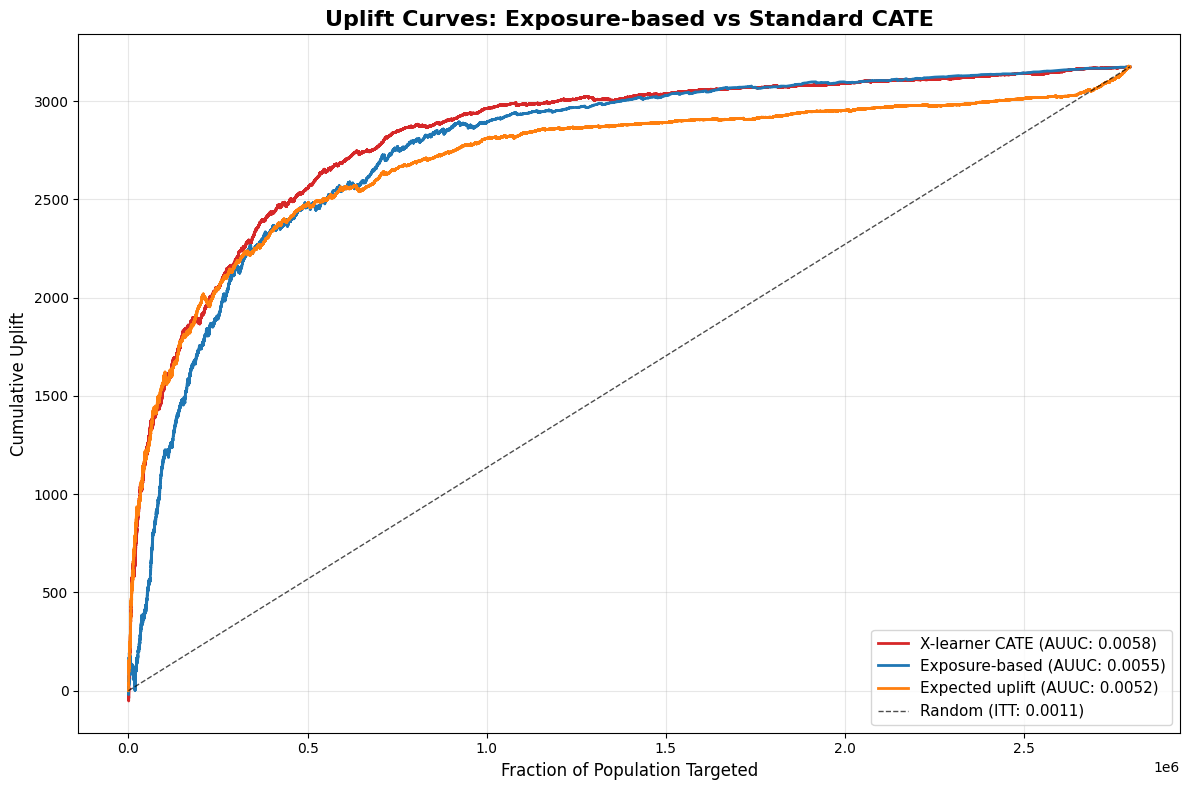

In [ ]:
# Uplift Curves Comparison - All Three Strategies
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#d62728', '#1f77b4', '#ff7f0e']  # Red, Blue, Orange
strategy_names = ['X-learner CATE', 'Exposure-based', 'Expected uplift']
strategy_scores = [x_cate_test, p_exposure_test, p_exposure_late_test]
auuc_scores = [cate_auuc, exposure_auuc, expected_uplift_auuc]

for i, (strategy, scores, auuc) in enumerate(zip(strategy_names, strategy_scores, auuc_scores)):
    # Calculate uplift curve manually to avoid plotting conflicts
    x_actual, y_actual = uplift_curve(Y_test, scores, T_test)

    # Plot the curve directly
    ax.plot(x_actual, y_actual, color=colors[i],
            label=f'{strategy} (AUUC: {auuc:.4f})', linewidth=2)

# Add random baseline line
itt_test = Y_test[T_test==1].mean() - Y_test[T_test==0].mean()
total_test_obs = len(Y_test)
ax.plot([0, total_test_obs], [0, itt_test * total_test_obs], 'k--', alpha=0.7,
        label=f'Random (ITT: {itt_test:.4f})', linewidth=1)

ax.set_title('Uplift Curves: Exposure-based vs Standard CATE', fontsize=16, fontweight='bold')
ax.set_xlabel('Fraction of Population Targeted', fontsize=12)
ax.set_ylabel('Cumulative Uplift', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

 ## Summary

 **From Black Box to Actionable Strategy**

 CATE gives one targeting score. Decomposition gives two: who can be reached (P(E)) and who responds when reached (LATE). This enables differentiated bidding strategies impossible with CATE alone

 | Approach          | AUUC          | Qini          | Business Application                                      |
 |-------------------|---------------|---------------|-----------------------------------------------------------|
 | X-learner CATE    | 0.0058        | 0.1753        | Single signal: "Target this user"                         |
 | P(E\|T=1,X) only  | 0.0055 (-5%)  | 0.1668 (-5%)  | One signal: "Easy to reach" (proves exposure drives CATE) |
 | P(E)×LATE(X)      | 0.0052 (-10%) | 0.1580 (-10%) | Two signals: "Easy to reach" + "Strong responder"         |

 **Why Two Signals Beat One**

 Two users with identical CATE score (0.004):
 - **User A**: P(E)=0.80, LATE=0.005 → Easy to reach, modest response → **Bid LOW** (save budget)
 - **User B**: P(E)=0.20, LATE=0.020 → Hard to reach, strong response → **Bid HIGH** (worth the cost)

 CATE can't tell them apart. Decomposition enables optimal bidding for each

 **The 10% Ranking Decline Enables Better Decisions**

 Lower ranking performance isn't a bug—it's separating two mechanisms CATE conflates:
 - **P(E) mechanism**: Improve via auction strategy (bid more, better inventory, fix delivery)
 - **LATE mechanism**: Improve via ad experience (better creative, offers, landing pages)

 CATE tells you "this user is valuable" but not why. Decomposition tells you if poor performance is auction losses (bid higher) or weak response (improve creative)

 What you can do now:
 1. Diagnose which mechanism is the bottleneck
 2. Optimize auction strategy and creative separately
 3. Allocate budget based on reachability cost vs response value

 **When to Use Each Approach**

 - **CATE (0.0058 AUUC)**:
   - Use when: Fixed bids only (platform limits or operational simplicity)
   - Strategy: Rank by CATE, apply uniform bid
   - Limitation: Can't tell if low performance is auction losses or poor response

 - **P(E)×LATE(X) (0.0052 AUUC)**:
   - Use when: Dynamic bidding available
   - Strategy: Optimize expected ROI = [P(E) × LATE × ConversionValue] - BidCost
     - High P(E), High LATE → Bid up to max willingness-to-pay
     - High P(E), Low LATE → Bid LOW (easy reach, limited upside)
     - Low P(E), High LATE → Bid HIGH if ROI positive (expensive reach, high value)
     - Low P(E), Low LATE → Skip
   - Value: Separate optimization of auction strategy (P(E)) and creative (LATE)

 **Note**: P(E) alone hits 95% of CATE performance — proving exposure dominates — but ignores response (not a viable strategy)

 **Conclusion**

 The 10% decline trades ranking performance for operational control. In auction environments, this enables delivery optimization, creative optimization, and dynamic bidding impossible with CATE's black-box score
